In [101]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
import datetime
warnings.filterwarnings("ignore")

In [102]:
data=pd.read_csv('./data/cases_train_processed.csv')

In [104]:
data['age']=data['age'].fillna(np.mean(data['age']))
data['sex']=data['sex'].fillna(999)
data['date_confirmation']=data['date_confirmation'].fillna(data.date_confirmation.mode()[0])
data['source']=data['source'].fillna(data.source.mode()[0])

In [105]:
del data['additional_information']

In [106]:
for col in data.columns:
    if data[col].dtype=='object':
        data[col]=data[col].fillna(data[col].mode()[0])
    else:
        data[col]=data[col].fillna(np.mean(data[col]))

In [107]:
data.isna().sum()

age                    0
sex                    0
province               0
country                0
latitude               0
longitude              0
date_confirmation      0
source                 0
outcome                0
Last_Update            0
Lat                    0
Long_                  0
Confirmed              0
Deaths                 0
Recovered              0
Active                 0
Combined_Key           0
Incidence_Rate         0
Case_Fatality_Ratio    0
dtype: int64

In [108]:
data.nunique()

age                     156
sex                       3
province               1106
country                  66
latitude               7110
longitude              7107
date_confirmation       154
source                 6841
outcome                   4
Last_Update               1
Lat                     370
Long_                   360
Confirmed               364
Deaths                  302
Recovered               264
Active                  332
Combined_Key            370
Incidence_Rate          371
Case_Fatality_Ratio     360
dtype: int64

In [109]:
for col in ['date_confirmation','Last_Update']:
    data[col+'month']=data[col].apply(lambda x:int(str(x).split()[0].split('/')[1]))
    data[col+'day']=data[col].apply(lambda x:int(str(x).split()[0].split('/')[2]))
    del data[col]
    
for col in ['sex','province','country','source','Combined_Key']:
    codes, uniques = pd.factorize(data[col])
    data[col]=codes
    
data['outcome']=data['outcome'].apply(lambda x:1 if x=='hospitalized' else 0)

2.split data

In [111]:
cols=[col for col in data.columns if col!='outcome']

In [112]:
y=data['outcome']
X=data[cols]

In [113]:
X.corr()

,age,sex,province,country,latitude,longitude,source,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case_Fatality_Ratio,date_confirmationmonth,date_confirmationday,Last_Updatemonth,Last_Updateday
age,1.000000,-0.002755,0.010572,0.035316,0.109761,-0.017569,0.011560,0.071072,-0.042255,-0.026805,-0.010320,-0.036982,0.004222,0.025087,-0.002512,0.048891,-0.097386,-0.006856,NaN,NaN
sex,-0.002755,1.000000,0.166027,0.210179,-0.271898,-0.627608,-0.070075,-0.170920,-0.584783,-0.326455,-0.270150,-0.392480,-0.070440,0.116130,0.346470,0.243501,-0.252061,-0.103120,NaN,NaN
province,0.010572,0.166027,1.000000,0.821570,0.014482,-0.332027,0.548967,0.075609,-0.282276,-0.164285,-0.152695,-0.207760,-0.010167,0.754958,0.101650,0.119565,-0.344225,-0.031403,NaN,NaN
country,0.035316,0.210179,0.821570,1.000000,0.003900,-0.400119,0.578597,0.031103,-0.387200,-0.130487,-0.085195,-0.218474,0.112957,0.740434,0.211753,0.226697,-0.390803,-0.044370,NaN,NaN
latitude,0.109761,-0.271898,0.014482,0.003900,1.000000,0.467776,0.190341,0.786806,0.306537,-0.155177,-0.151288,-0.053591,-0.340422,0.107232,-0.579516,0.018204,-0.311833,0.015119,NaN,NaN
longitude,-0.017569,-0.627608,-0.332027,-0.400119,0.467776,1.000000,0.034255,0.320651,0.833910,0.284673,0.135906,0.433978,-0.142949,-0.272086,-0.593826,-0.492662,0.164165,0.112945,NaN,NaN
source,0.011560,-0.070075,0.548967,0.578597,0.190341,0.034255,1.000000,0.168828,-0.010067,-0.147043,-0.180097,-0.164156,-0.055934,0.602863,-0.065257,-0.109832,-0.319748,-0.009667,NaN,NaN
Lat,0.071072,-0.170920,0.075609,0.031103,0.786806,0.320651,0.168828,1.000000,0.382979,-0.191727,-0.180871,-0.067095,-0.419089,0.079319,-0.729872,0.029658,-0.284430,-0.004410,NaN,NaN
Long_,-0.042255,-0.584783,-0.282276,-0.387200,0.306537,0.833910,-0.010067,0.382979,1.000000,0.357903,0.181527,0.534371,-0.154532,-0.391928,-0.708004,-0.587269,0.227520,0.113280,NaN,NaN
Confirmed,-0.026805,-0.326455,-0.164285,-0.130487,-0.155177,0.284673,-0.147043,-0.191727,0.357903,1.000000,0.940024,0.959280,0.770414,-0.271907,0.093648,-0.125535,0.238993,0.108307,NaN,NaN


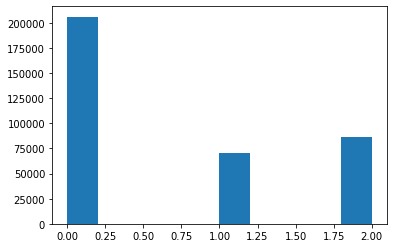

In [114]:
plt.hist(data['sex'])
plt.show()

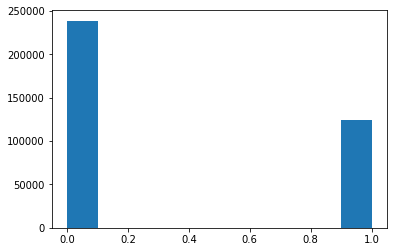

In [115]:
plt.hist(y)
plt.show()

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
sca=StandardScaler()
X=sca.fit_transform(X)

In [118]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)

3.build model

In [119]:
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
import math
import pickle

In [ ]:
def model_lgb_train(trainX,trainy,params):
    model=lgb.LGBMClassifier(**params)
    model.fit(trainX,trainy,early_stopping_rounds=30,eval_set=[(X_train, y_train),(X_val, y_val)],verbose=0)
    return model

def model_lgb_val(valX,model):
    pred=model.predict(valX)
    return pred

In [125]:
def model_svr_train(trainX,trainy,params):
    model=SVC(**params)
    model.fit(trainX,trainy)
    return model

def model_svr_val(valX,model):
    pred=model.predict(valX)
    return pred

In [121]:
def model_mlp_train(trainX,trainy,params):
    model=MLPClassifier(**params)
    model.fit(trainX,trainy)
    return model

def model_mlp_val(valX,model):
    pred=model.predict(valX)
    return pred

In [122]:
params_lgb={ 'boosting_type':'gbdt','objective':'binary',
            'learning_rate':0.1, 'n_estimators':500, 'max_depth':5,
            'metric':'binary_logloss', 'bagging_fraction':0.8, 'feature_fraction':0.8, 'reg_lambda':0.9,'verbose':1000,'silent':False
}

params_svr={
    'kernel' :'rbf','degree' : 3,'gamma' :'auto','tol' : 0.001
}

params_mlp={
    'hidden_layer_sizes':(100,50), 'activation':'relu','solver':'adam',
    'alpha':0.02,'max_iter':200
}

In [123]:
model_lgb=model_lgb_train(X_train, y_train,params_lgb)
output = open('./models/lgb_classifier.pkl', 'wb')
pickle.dump(model_lgb, output)
output.close()
model_lgb=pickle.load(open('./models/lgb_classifier.pkl', 'rb'))
pred_lgb_val=model_lgb_val(X_val,model_lgb)
pred_lgb_train=model_lgb_val(X_train,model_lgb)
print('the train acc of lgb is '+str(accuracy_score(pred_lgb_train,y_train)))
print('the train f1 of lgb is '+str(f1_score(pred_lgb_train,y_train)))

print('the val acc of lgb is '+str(accuracy_score(pred_lgb_val,y_val)))
print('the  val f1 of lgb is '+str(f1_score(pred_lgb_val,y_val)))

the train acc of lgb is 0.8876399471845515
the train f1 of lgb is 0.8440141870378591
the val acc of lgb is 0.8839573075124474
the  val f1 of lgb is 0.8390591915762167


In [ ]:
model_svr=model_svr_train(X_train, y_train,params_svr)
output = open('./models/svc_classifier.pkl', 'wb')
pickle.dump(model_svr, output)
output.close()
model_svr=pickle.load(open('./models/svc_classifier.pkl', 'rb'))
pred_svr_val=model_svr_val(X_val,model_svr)
pred_svr_train=model_svr_val(X_train,model_svr)

print('the train acc of svm is '+str(accuracy_score(pred_svr_train,y_train)))
print('the train f1 of svm is '+str(f1_score(pred_svr_train,y_train)))

print('the val acc of svm is '+str(accuracy_score(pred_svr_val,y_val)))
print('the  val f1 of svm is '+str(f1_score(pred_svr_val,y_val)))

the train acc of svr is 0.8186119439936181
the train f1 of svr is 0.7447722632398904
the val acc of svr is 0.8178829807718758
the  val f1 of svr is 0.7435654110583906


In [ ]:
model_mlp=model_mlp_train(X_train, y_train,params_mlp)
output = open('./models/mlp_classifier.pkl', 'wb')
pickle.dump(model_mlp, output)
output.close()
model_mlp=pickle.load(open('./models/mlp_classifier.pkl', 'rb'))
pred_mlp_val=model_mlp_val(X_val,model_mlp)
pred_mlp_train=model_mlp_val(X_train,model_mlp)

print('the train acc of mlp is '+str(accuracy_score(pred_mlp_train,y_train)))
print('the train f1 of mlp is '+str(f1_score(pred_mlp_train,y_train)))

print('the val acc of mlp is '+str(accuracy_score(pred_mlp_val,y_val)))
print('the  val f1 of mlp is '+str(f1_score(pred_mlp_val,y_val)))

the train acc of mlp is 0.85297980909416
the train f1 of mlp is 0.8088329316874047
the val acc of mlp is 0.8508926360960581
the  val f1 of mlp is 0.8059151046422114


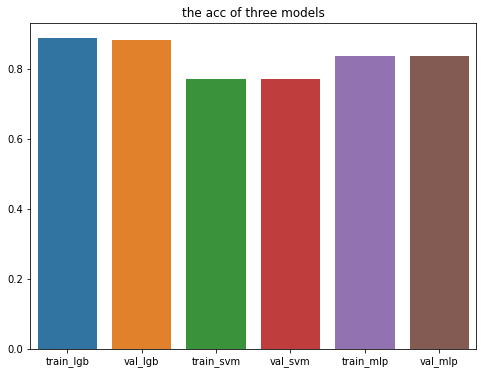

In [126]:
fig = plt.figure(figsize=(8,6))

sns.barplot(['train_lgb','val_lgb','train_svm','val_svm','train_mlp','val_mlp']
            ,[accuracy_score(pred_lgb_train,y_train),accuracy_score(pred_lgb_val,y_val),
              accuracy_score(pred_svr_train,y_train),accuracy_score(pred_svr_val,y_val),
              accuracy_score(pred_mlp_train,y_train),accuracy_score(pred_mlp_val,y_val),
             ])

plt.title('the acc of three models')

plt.savefig('./plots/accuracy.png')

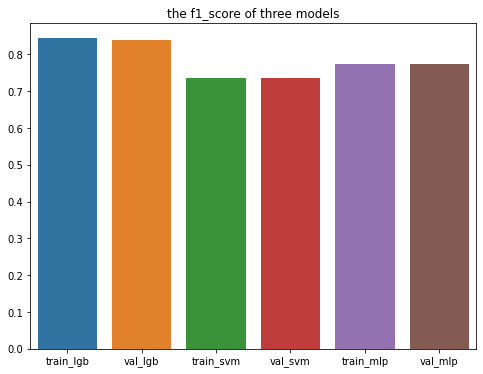

In [127]:
fig = plt.figure(figsize=(8,6))

sns.barplot(['train_lgb','val_lgb','train_svm','val_svm','train_mlp','val_mlp']
            ,[f1_score(pred_lgb_train,y_train),f1_score(pred_lgb_val,y_val),
              f1_score(pred_svr_train,y_train),f1_score(pred_svr_val,y_val),
              f1_score(pred_mlp_train,y_train),f1_score(pred_mlp_val,y_val),
             ])

plt.title('the f1_score of three models')

plt.savefig('./plots/f1_score.png')

In [ ]:
params_lgb1={ 'boosting_type':'gbdt','objective':'binary',
            'learning_rate':0.3, 'n_estimators':500, 'max_depth':5,
            'metric':'binary_logloss', 'bagging_fraction':0.8, 'feature_fraction':0.8, 'reg_lambda':0.9,'verbose':0,
}

params_svr1={
    'kernel' :'linear','degree' : 5,'gamma' :'auto','tol' : 0.001
}

params_mlp1={
    'hidden_layer_sizes':(100,50), 'activation':'relu','solver':'adam',
    'alpha':0.1,'max_iter':400
}

In [ ]:
model_lgb=model_lgb_train(X_train, y_train,params_lgb1)
pred_lgb_val=model_lgb_val(X_val,model_lgb)
pred_lgb_train=model_lgb_val(X_train,model_lgb)
print('the train acc of lgb1 is '+str(accuracy_score(pred_lgb_train,y_train)))
print('the train f1 of lgb1 is '+str(f1_score(pred_lgb_train,y_train)))

print('the val acc of lgb1 is '+str(accuracy_score(pred_lgb_val,y_val)))
print('the  val f1 of lgb1 is '+str(f1_score(pred_lgb_val,y_val)))

the train acc of lgb1 is 0.9001423541385856
the train f1 of lgb1 is 0.859573027731438
the val acc of lgb1 is 0.8944928891700823
the  val f1 of lgb1 is 0.8516677946437203


In [ ]:
model_svr=model_svr_train(X_train, y_train,params_svr1)
pred_svr_val=model_svr_val(X_val,model_svr)
pred_svr_train=model_svr_val(X_train,model_svr)

print('the train acc of svm1 is '+str(accuracy_score(pred_svr_train,y_train)))
print('the train f1 of svm1 is '+str(f1_score(pred_svr_train,y_train)))

print('the val acc of svm1 is '+str(accuracy_score(pred_svr_val,y_val)))
print('the  val f1 of svm1 is '+str(f1_score(pred_svr_val,y_val)))

the train acc of svc1 is 0.7721646081478832
the train f1 of svc1 is 0.7368400149333164
the val acc of svc1 is 0.7704040931972602
the  val f1 of svc1 is 0.7348254991977888


In [ ]:
model_mlp=model_mlp_train(X_train, y_train,params_mlp1)
pred_mlp_val=model_mlp_val(X_val,model_mlp)
pred_mlp_train=model_mlp_val(X_train,model_mlp)

print('the train acc of mlp1 is '+str(accuracy_score(pred_mlp_train,y_train)))
print('the train f1 of mlp1 is '+str(f1_score(pred_mlp_train,y_train)))

print('the val acc of mlp1 is '+str(accuracy_score(pred_mlp_val,y_val)))
print('the  val f1 of mlp1 is '+str(f1_score(pred_mlp_val,y_val)))

the train acc of mlp1 is 0.837056088906005
the train f1 of mlp1 is 0.7741578816935775
the val acc of mlp1 is 0.8366847302836079
the  val f1 of mlp1 is 0.7734488285125544
